# Toronto Neighborhood Analysis for Renting/Buying a house

## Business Problem


People like to gather a lot of information about one or more preferred locations before deciding to rent/buy a house  in a new location. Factors that influence this decision include population in the new locality, house price, nearby schools, crime rates etc. This project focus to help people select the best locality to move in based on features for a neighborhood or a comparison between neighborhoods thus saving a lot of time and money.

 As a sample, this project will  compare 2 neighborhoods of Toronto and analyze the similarities and dissimilarities between the two chosen neighborhoods to conclude with ease which neighborhood is the best.

## Data

The necessary information needed for data analysis

1) https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/  for providing an overview of the neighborhoods in Toronto  <br/>
2) https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv The Census of Population is held across Canada every five years (the last being in 2016), and collects data about age and sex, families and households, language, immigration and internal migration, ethnocultural diversity, Aboriginal peoples, housing, education, income, and labor. <br/>
3) https://open.toronto.ca/dataset/neighbourhoods/ GeoJson file for Toronto <br/>
4) Foursquare API to collect information on most common venues of Borough of Toronto <br/>
5) Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M for Toronto Neighborhood Borough Designation <br/>
6) http://cocl.us/Geospatial_data that has the geographical coordinates of each postal code 

# Methodology

In order to select the neighborhood, we will explore the neighborhoods in the city of Toronto by Segmenting and Clustering . 

In [1]:

#Importing libraries 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

 

### convert csv file http://cocl.us/Geospatial_data that has the geographical coordinates of each postal code to pandas dataframe

In [2]:

url = 'https://github.com/steffim88/Coursera_Capstone/blob/master/Geospatial_Coordinates.csv'
wiki_html = requests.get(url).text
soup = BeautifulSoup(wiki_html, 'html.parser')

data = []
for tr in soup.tbody.find_all('tr'):
    data.append([ td.get_text().strip() for td in tr.find_all('td')])


df_geo = pd.DataFrame(data, columns=['Index','Postal Code','Latitude','Longitude'])
df_geo = df_geo[['Postal Code','Latitude','Longitude']]
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.8066863,-79.1943534
1,M1C,43.7845351,-79.1604971
2,M1E,43.7635726,-79.1887115
3,M1G,43.7709921,-79.2169174
4,M1H,43.773136,-79.2394761


### scrape the Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe 

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_html = requests.get(url).text
soup = BeautifulSoup(wiki_html, 'html.parser')

data = []
for tr in soup.tbody.find_all('tr'):
    data.append([ td.get_text().strip() for td in tr.find_all('td')])
df = pd.DataFrame(data, columns=['PostalCode','Borough','Neighborhood'])
df.dropna(inplace = True)
df = df[(df.Borough != 'Not assigned') ]
def list_neighborhood(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
df_final = df.groupby(['PostalCode', 'Borough']).apply(list_neighborhood).reset_index(name='Neighborhood')
df_final.loc[df_final['Neighborhood'] == 'Not assigned', 'Neighborhood'] = df_final['Borough']
df_final.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


    Merge both the dataframes using postal code to find the geo cordinates for neighborhood of Toronto

In [4]:
df_new = pd.concat([df_final,df_geo ] ,axis=1)
df_new.head()
df_new = df_new[ df_new.Borough.str.contains('Toronto') ]
df_new.head()

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
37,M4E,East Toronto,The Beaches,M4E,43.6763574,-79.2930312
41,M4K,East Toronto,"Riverdale, The Danforth West",M4K,43.6795571,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",M4L,43.6689985,-79.3155716
43,M4M,East Toronto,Studio District,M4M,43.6595255,-79.340923
44,M4N,Central Toronto,Lawrence Park,M4N,43.7280205,-79.3887901


Now lets Plot the Neighborhood of Toronto using geo cordinates on map using folium

In [5]:
#import libraries
!pip install folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
toronto_coords = [43.653226, -79.3831843]
map_toronto = folium.Map(location=[toronto_coords[0], toronto_coords[1]], zoom_start=12)
for lat, lng, borough, neighborhood in zip(df_new['Latitude'], df_new['Longitude'], df_new['Borough'], df_new['Neighborhood']):
    label = '{} - {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto


### Using Foursquare API to collect information on most common venues of Borough of Toronto

In [6]:
toronto_data = pd.DataFrame(df_new)
toronto_data = toronto_data.reset_index().drop('index', axis=1)
toronto_data.head()
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] 
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] 
neighborhood_name = toronto_data.loc[0, 'Neighborhood']
VERSION = '20180605'
CLIENT_ID = 'JWUMXPYGSPA2V4NOTS2RYPEDTDD1XCGZ5RIMK3HWGP3HMZI4'
CLIENT_SECRET = 'F2XQYTAHZCEK2M3UDVQXFMKZGJABJG4ZM0ZHBFBKO223H3IZ'
latitude = neighborhood_latitude
longitude = neighborhood_longitude
radius = 500
LIMIT = 100
#api call
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION,radius, LIMIT)
results = requests.get(url).json()
venues=results['response']['groups'][0]['items']
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

nearby_venues = json_normalize(venues)
nearby_venues.columns
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues["venue.categories"][1]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869
4,Dip 'n Sip,Coffee Shop,43.678897,-79.297745


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
print ('Nearby Venues') 
print ('-------------')
toronto_venues = getNearbyVenues(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'])


Nearby Venues
-------------
The Beaches
Riverdale, The Danforth West
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, The Annex, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Park

In [9]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
"Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
Berczy Park,57,57,57,57,57,57
"Brockton, Exhibition Place, Parkdale Village",21,21,21,21,21,21
Business Reply Mail Processing Centre 969 Eastern,19,19,19,19,19,19
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,84,84,84,84,84,84
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


### Analyze Each Neighborhood

In [10]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.00,0.000000,0.00000,0.00,0.010000,0.000000,0.000000,0.000000,0.010000,0.01
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.142857,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
2,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.00
3,"Brockton, Exhibition Place, Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Business Reply Mail Processing Centre 969 Eastern,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,Central Bay Street,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.00,0.000000,0.00000,0.00,0.011905,0.000000,0.011905,0.000000,0.011905,0.00
7,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.01,0.000000,0.00000,0.00,0.060000,0.000000,0.000000,0.040000,0.010000,0.00
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Church and Wellesley,0.011905,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.00,0.000000,0.00000,0.00,0.000000,0.011905,0.000000,0.011905,0.000000,0.00


In [12]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print(hood)
    print('---------------------------------------------------------------------------------------------------------------------------------------------')
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

Adelaide, King, Richmond
---------------------------------------------------------------------------------------------------------------------------------------------
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.05
2           Steakhouse  0.04
3                  Bar  0.04
4      Thai Restaurant  0.04
5     Asian Restaurant  0.03
6                  Gym  0.03
7       Breakfast Spot  0.03
8  American Restaurant  0.03
9                Hotel  0.03
Bathurst Quay, CN Tower, Harbourfront West, Island airport, King and Spadina, Railway Lands, South Niagara
---------------------------------------------------------------------------------------------------------------------------------------------
                venue  freq
0      Airport Lounge  0.14
1     Airport Service  0.14
2    Airport Terminal  0.14
3         Coffee Shop  0.07
4     Harbor / Marina  0.07
5             Airport  0.07
6  Airport Food Court  0.07
7        Airport Gate  0.07
8    Sculptur

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
import numpy as np
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant
1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",Airport Service,Airport Terminal,Airport Lounge,Plane,Sculpture Garden
2,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse
3,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Furniture / Home Store,Intersection
4,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden
5,"Cabbagetown, St. James Town",Park,Coffee Shop,Café,Pizza Place,Convenience Store
6,Central Bay Street,Coffee Shop,Ice Cream Shop,Italian Restaurant,Sandwich Place,Burger Joint
7,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bakery,Vietnamese Restaurant
8,Christie,Café,Grocery Store,Park,Diner,Convenience Store
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant


### Cluster Neighborhood

In [14]:
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]
toronto_merged = toronto_data

toronto_merged['Cluster Labels'] = kmeans.labels_

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4E,East Toronto,The Beaches,M4E,43.6763574,-79.2930312,0,Health Food Store,Trail,Pub,Coffee Shop,Farmers Market
1,M4K,East Toronto,"Riverdale, The Danforth West",M4K,43.6795571,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
2,M4L,East Toronto,"India Bazaar, The Beaches West",M4L,43.6689985,-79.3155716,0,Pizza Place,Fast Food Restaurant,Italian Restaurant,Pet Store,Gym
3,M4M,East Toronto,Studio District,M4M,43.6595255,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant
4,M4N,Central Toronto,Lawrence Park,M4N,43.7280205,-79.3887901,0,Park,Bus Line,Dim Sum Restaurant,Swim School,Women's Store


### Plot map after clustering

In [15]:
map_clusters = folium.Map(location=[toronto_coords[0], toronto_coords[1]], zoom_start=12)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster 1

In [16]:
df0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df0

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,The Beaches,-79.2930312,0,Health Food Store,Trail,Pub,Coffee Shop,Farmers Market
1,"Riverdale, The Danforth West",-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
2,"India Bazaar, The Beaches West",-79.3155716,0,Pizza Place,Fast Food Restaurant,Italian Restaurant,Pet Store,Gym
3,Studio District,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant
4,Lawrence Park,-79.3887901,0,Park,Bus Line,Dim Sum Restaurant,Swim School,Women's Store
5,Davisville North,-79.3901975,0,Breakfast Spot,Hotel,Sandwich Place,Clothing Store,Food & Drink Shop
6,North Toronto West,-79.4056784,0,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Diner
7,Davisville,-79.3887901,0,Sandwich Place,Dessert Shop,Pizza Place,Café,Restaurant
8,"Moore Park, Summerhill East",-79.3831599,0,Playground,Gym,Restaurant,Park,Women's Store
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",-79.4000493,0,Coffee Shop,Pub,Pizza Place,Sushi Restaurant,Fried Chicken Joint


### Cluster 2

In [17]:
df1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df1

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
26,"Chinatown, Grange Park, Kensington Market",-79.4000493,1,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Bakery,Vietnamese Restaurant
31,"Dovercourt Village, Dufferin",-79.4422593,1,Bakery,Pharmacy,Supermarket,Pizza Place,Coffee Shop


### Cluster 3

In [18]:
df2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df2

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
32,"Little Portugal, Trinity",-79.4197497,2,Bar,Coffee Shop,Asian Restaurant,Cocktail Bar,Boutique


### Cluster 4

In [ ]:
df3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df3

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Central Bay Street,-79.3873826,3,Coffee Shop,Ice Cream Shop,Italian Restaurant,Sandwich Place,Burger Joint


### Cluster 5

In [ ]:
df4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
df4

,Neighborhood,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
24,"North Midtown, The Annex, Yorkville",-79.4056784,4,Coffee Shop,Sandwich Place,Café,Pizza Place,BBQ Joint


In [ ]:
clusters=pd.DataFrame({"Cluster0":df0["Neighborhood"],
                       "Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster3":df3["Neighborhood"],
                      "Cluster4":df4["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [ ]:
clusters

,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4
0,The Beaches,,,,
1,"Riverdale, The Danforth West",,,,
2,"India Bazaar, The Beaches West",,,,
3,Studio District,,,,
4,Lawrence Park,,,,
5,Davisville North,,,,
6,North Toronto West,,,,
7,Davisville,,,,
8,"Moore Park, Summerhill East",,,,
9,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",,,,


### Resulting dataframe shows the 5 most common venue in the Neighborhood of Toronto

In [ ]:
toronto=toronto_merged.set_index("Neighborhood",drop=True)
toronto.head()


,PostalCode,Borough,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,,,,,,
The Beaches,M4E,East Toronto,M4E,43.6763574,-79.2930312,0,Health Food Store,Trail,Pub,Coffee Shop,Farmers Market
"Riverdale, The Danforth West",M4K,East Toronto,M4K,43.6795571,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
"India Bazaar, The Beaches West",M4L,East Toronto,M4L,43.6689985,-79.3155716,0,Pizza Place,Fast Food Restaurant,Italian Restaurant,Pet Store,Gym
Studio District,M4M,East Toronto,M4M,43.6595255,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant
Lawrence Park,M4N,Central Toronto,M4N,43.7280205,-79.3887901,0,Park,Bus Line,Dim Sum Restaurant,Swim School,Women's Store


### Plot a bar chart showing average school ratings in Neighborhood of Toronto . Note: values are hard coded

In [ ]:
Toronto_school_ratings=pd.DataFrame({"Neighborhood":toronto_merged["Neighborhood"],
                                      "Top School Rating":[8,9,9,8,10,10,7,10,0,0,8,9,9,8,10,10,7,10,0,0,8,9,9,8,10,10,7,10,0,0,8,9,9,8,10,10,7,10]})
Toronto_school_ratings.set_index('Neighborhood',inplace=True,drop=True)
Toronto_school_ratings.plot(kind='bar',figsize=(10,7),color='green',alpha=0.75);

### Plot a bar chart showing average house price in Neighborhood of Toronto . Note: values are hard coded

In [ ]:
Toronto_Avg_HousingPrice=pd.DataFrame({"Neighborhood":toronto_merged["Neighborhood"],
                                      "Average_Housing_Price":[172050.0,343500.0,297900.0,202000.0,
                                                               573900.0,279400.0,178000.0,275000.0,275000.0,477000.0,172050.0,343500.0,297900.0,202000.0,
                                                               573900.0,279400.0,178000.0,275000.0,275000.0,477000.0, 172050.0,343500.0,297900.0,202000.0,
                                                               573900.0,279400.0,178000.0,275000.0,275000.0,477000.0, 172050.0,343500.0,297900.0,202000.0,
                                                               573900.0,279400.0,178000.0,275000.0]})

Toronto_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)
Toronto_Avg_HousingPrice.plot(kind='bar',figsize=(10,7),color='orange',alpha=0.75);

### Plot a bar chart showing crime rate  in Neighborhood of Toronto . Note: values are hard coded

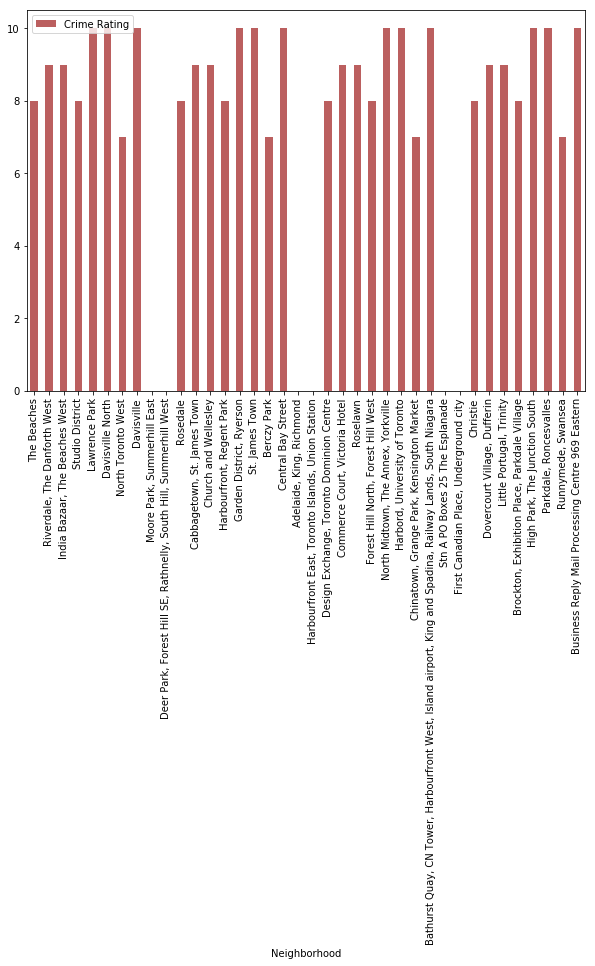

In [ ]:
Toronto_Crime_ratings=pd.DataFrame({"Neighborhood":toronto_merged["Neighborhood"],
                                      "Crime Rating":[8,9,9,8,10,10,7,10,0,0,8,9,9,8,10,10,7,10,0,0,8,9,9,8,10,10,7,10,0,0,8,9,9,8,10,10,7,10]})
Toronto_Crime_ratings.set_index('Neighborhood',inplace=True,drop=True)
Toronto_Crime_ratings.plot(kind='bar',figsize=(10,7),color='brown',alpha=0.75);

### Plot a bar chart showing population in Neighborhood of Toronto . Note: values are hard coded

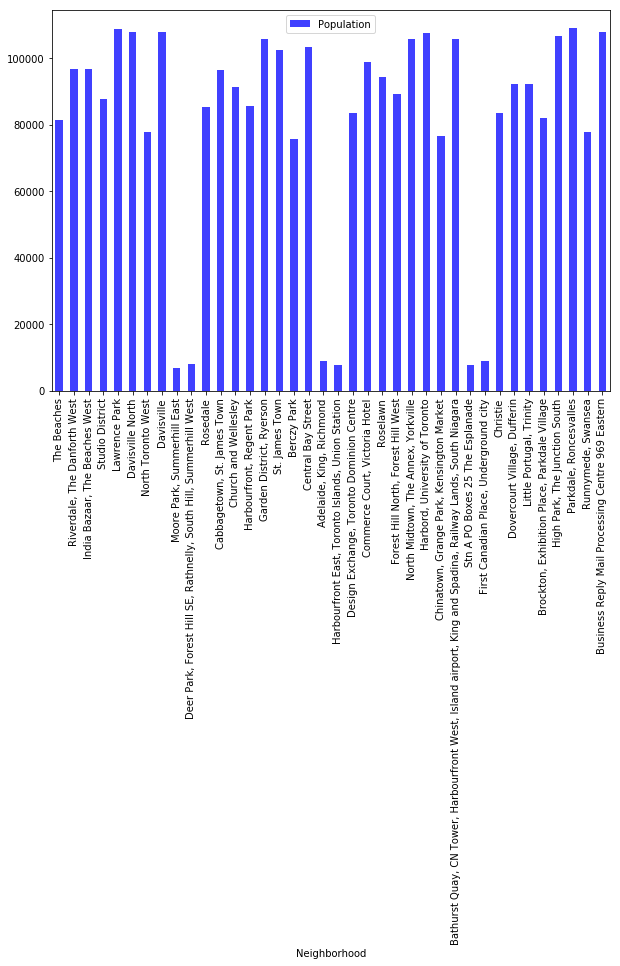

In [ ]:
Toronto_Population=pd.DataFrame({"Neighborhood":toronto_merged["Neighborhood"],
                                      "Population":[81345,96766,96775,87767,108909,107767,77777,107878,6767,7878,85444,96544,91234,85544,105678,102345,75678,103322,8978,7654,83456,98787,94434,89087,105645,107687,76543,105643,7865,8976,83434,92323,92312,82121,106767,108976,77878,107865]})
Toronto_Population.set_index('Neighborhood',inplace=True,drop=True)
Toronto_Population.plot(kind='bar',figsize=(10,7),color='blue',alpha=0.75);

### Compare between 2 Neighborhoods of Toroto.  

In [ ]:
Neiborhood1=input("Enter the Neighborhood: ")

In [ ]:
Neiborhood2=input("Enter the Neighborhood: ")

### Comparison of 2 Neighborhood based on the top 5 common place

In [ ]:
Venue_comparison=toronto.loc[[Neiborhood1,Neiborhood2]].T
Venue_comparison

### Comparison of 2 Neighborhood based on population

In [ ]:
Population_Comparison=Toronto_Population.loc[[Neiborhood1,Neiborhood2]]
Population_Comparison.plot(kind='bar',alpha=0.75)

In [ ]:
Population_Comparison

### Comparison of 2 Neighborhood based on School Ratings

In [ ]:
School_rating_comparison=Toronto_school_ratings.loc[[Neiborhood1,Neiborhood2]]
School_rating_comparison.plot(kind='bar',alpha=0.75);

In [ ]:
School_rating_comparison

### Comparison of 2 Neighborhood based on average house price

In [ ]:
Avg_housing_price_comparison=Toronto_Avg_HousingPrice.loc[[Neiborhood1,Neiborhood2]]
Avg_housing_price_comparison.plot(kind='bar',alpha=0.75);
Avg_housing_price_comparison

# Conclusion

This Analysis concludes that compared to Neighborhood1,  Neighborhood2 has the higher number of  population ,good school rating , less crime rate and a reasonable avg housing price  ,also top 10 common venues shows Neighborhood2 has gotton a good neighborhood.Hence Neighborhood2 wins over Neighborhood1.